## Ejerccio de Tarea 01
Para los datos de la [Liga Nacional de Fútbol](https://github.com/HaydeePeruyero/MultivariateStatisticalAnalysis/blob/main/data/Liga_nacional_de_futbol.csv)

**a**. Ajustar un modelo de regresión lineal múltiple que relacione la cantidad de juegos ganados con las yardas por aire del equipo ($x_2$), el porcentaje de jugadas por tierra ($x_7$) y las yardas por tierra del contrario ($x_8$).  

**b**. Formar la tabla de análisis de varianza y probar la significancia de la regresión.  

**c**. Calcular el estadístico *t* para probar las hipótesis $H_0 : \beta_2 = 0$, $H_0 : \beta_7 = 0$ y $H_0 : \beta_8 = 0$. ¿Qué conclusiones se pueden sacar acerca del papel de las variables $x_2$, $x_7$ y $x_8$ en el modelo?  

**d**. Calcular $R^2$ y $R^2_{adj}$ para este modelo.  

**e**. Trazar una gráfica de probabilidad normal de los residuales. ¿Parece haber algún problema con la hipótesis de normalidad?  

**f**. Trazar e interpretar una gráfica de los residuales en función de la respuesta predicha.  

**g**. Trazar las gráficas de los residuales en función de cada una de las variables regresoras. ¿Implican esas gráficas que se especificó en forma correcta el regresor?  

**h**. Calcular un intervalo de confianza de $95\%$ para $\beta_7$ y un intervalo de confianza de $95\%$ para la cantidad media de juegos ganados por un equipo cuando $x_2 = 2300$, $x_7 = 56$ y $x_8 = 2100$.  

**i**. Ajustar un modelo a esos datos, usando solo $x_7$ y $x_8$ como regresores y probar la significancia de la regresión.  

**j**. Calcular $R^2$ y $R^2_{adj}$. Compararlos con los resultados del modelo anterior.  

**k**. Calcular un intervalo de confianza de $95\%$ para $\beta_7$. También, un intervalo de confianza de $95\%$ para la cantidad media de juegos ganados por un equipo cuando $x_7 = 56$ y $x_8 = 2100$. Comparar las longitudes de esos intervalos de confianza con las longitudes de los correspondientes al modelo anterior.  

**l**. ¿Qué conclusiones se pueden sacar de este problema, acerca de las consecuencias de omitir un regresor importante de un modelo?

## 0. Importar 

### 0.1. Importar Librerías

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats

### 0.2. Cargar Datos

In [15]:
DatasetFutbol = pd.read_csv(
    './Liga_nacional_de_futbol.csv',
)

TargetLabel , *FeatureLabels = DatasetFutbol.columns

DatasetFutbol.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,10,2113,1985,38.9,64.7,4,868,59.7,2205,1917
1,11,2003,2855,38.8,61.3,3,615,55.0,2096,1575
2,11,2957,1737,40.1,60.0,14,914,65.6,1847,2175
3,13,2285,2905,41.6,45.3,-4,957,61.4,1903,2476
4,10,2971,1666,39.2,53.8,15,836,66.1,1457,1866


## **a**. Modelo de Regresión

Por medio del plot generado, se puede apreciar que algunos de los atributos (variables de regresión) consideradas capturan una tendendecia o relación con la variable de respuesta. Esta variables son $x_7$ (porcentaje de jugadas por tierra) y $x_8$ (yardas por tierra del contrario), mientras que la variable $x_2$ (yardas por aire del equipo) tiene un comportamiento más aleatorio (o su tendencia no sea tan pronunciada).

In [212]:
# Ajuste de Modelo usando Funciones de Python 

FeaturesModel = ['x2','x7','x8']

LinearModel = smf.ols(
    f"{TargetLabel} ~ " + ' + '.join(FeaturesModel),
    data = DatasetFutbol,
).fit()

In [213]:
# Ajuste de Modelo de forma Manual

SizeN = DatasetFutbol.shape[0]

DataMatrixX = np.concat(
        [
            np.ones((SizeN,1)),
            DatasetFutbol[FeaturesModel].to_numpy()
        ],
        axis=1,
    )
RealValuesY = DatasetFutbol[[TargetLabel]].to_numpy()

EstimateBetas = np.linalg.inv(DataMatrixX.T@DataMatrixX) @ DataMatrixX.T @ RealValuesY

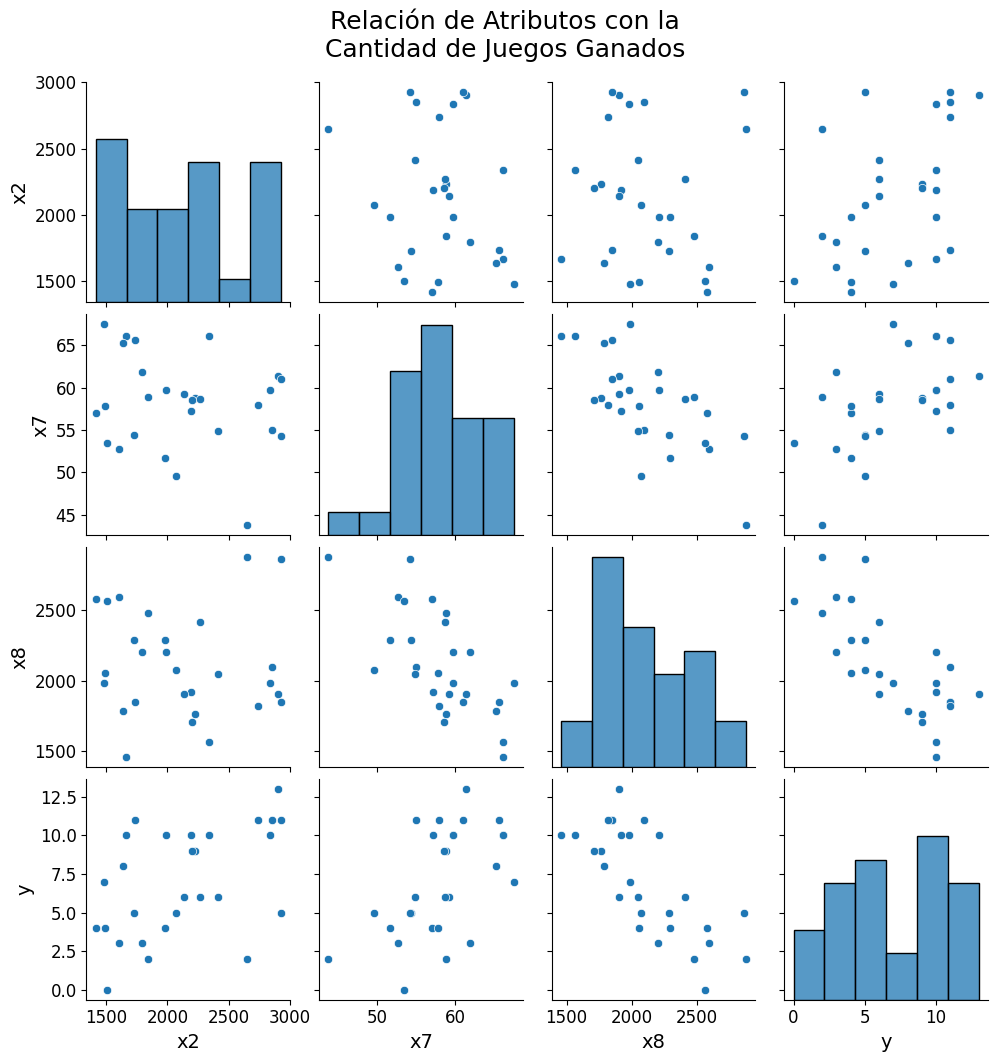

In [214]:
plot = sns.pairplot(
    DatasetFutbol[[*FeaturesModel,TargetLabel]],
)

plot.figure.suptitle(
    'Relación de Atributos con la\nCantidad de Juegos Ganados', 
    fontsize = 18,
    y = 1.05,
)

for ax in plot.axes.flat:
    ax.set_xlabel(
        ax.get_xlabel(),
        fontsize=14,
    )
    ax.set_ylabel(
        ax.get_ylabel(),
        fontsize=14,
    )
    
    ax.tick_params(
        axis = 'both',
        which = 'major',
        labelsize = 12,
    )

## **b**. Tabla de Análisis de Varianza

Usando los valores que se encuentran en la columna de `Cuadrados Medios`, permiten decir el modelo se ajusta adecuadamente, debido a que el valor en los Cuadrados Medios Residuales es un valor bajo. Aplicando la prueba de la significancia de la regresión, se tiene que el estadistico $F_0$ es mayor que a $F_1$ por lo que la cantidad de juegos ganados depende linealmente de las variables de estudio.

In [ ]:
def ANOVATable(
        LinearModel,
    ) -> pd.DataFrame:
    """
    Función para construir la tabla de ANOVA 
    en base a un modelo de Regresión Lineal, 
    se extraen los valores de interés y son 
    reacomodados en un formato tabular.
    """
    
    ColumnsANOVA = [
        'Fuente Variación',
        'Suma de Cuadrados',
        'Grados de Libertad',
        'Cuadrados Medios',
        'F_0',
    ]
    Table = pd.DataFrame(columns=ColumnsANOVA)
    Table['Fuente Variación'] = ['Regresión','Residuales','Total']

    MeanSquares_Reg = LinearModel.mse_model
    MeanSquares_Res = LinearModel.mse_resid
    MeanSquares_Tot = LinearModel.mse_total
    Table['Cuadrados Medios'] = [MeanSquares_Reg,MeanSquares_Res,MeanSquares_Tot]

    DegreeFreedom_Reg = LinearModel.df_model
    DegreeFreedom_Res = LinearModel.df_resid
    DegreeFreedom_Tot = DegreeFreedom_Reg + DegreeFreedom_Res
    Table['Grados de Libertad'] = [DegreeFreedom_Reg,DegreeFreedom_Res,DegreeFreedom_Tot]

    Table['Suma de Cuadrados'] = Table['Cuadrados Medios']*Table['Grados de Libertad']

    Table['F_0'] = [LinearModel.fvalue,np.nan,np.nan]

    return Table.set_index('Fuente Variación')

In [ ]:
def ANOVATable_Manual(
        DataMatrixX: np.ndarray,
        RealValuesY: np.ndarray,
        EstimateBetas: np.ndarray,
    ) -> pd.DataFrame:
    """
    Función para construir la tabla de ANOVA 
    en base a las observaciones (`DataMatrixX` y 
    `RealValuesY`) y los coeficientes de regresión 
    (`EstimateBetas`), se hacen uso de las formulas 
    matriciales para determinar los diferentes 
    valores de la tabla.
    """

    ColumnsANOVA = [
        'Fuente Variación',
        'Suma de Cuadrados',
        'Grados de Libertad',
        'Cuadrados Medios',
        'F_0',
    ]
    Table = pd.DataFrame(columns=ColumnsANOVA)
    Table['Fuente Variación'] = ['Regresión','Residuales','Total']

    SizeN = DataMatrixX.shape[0]
    SumSquares_Tot = (RealValuesY.T@RealValuesY - np.sum(RealValuesY)**2/SizeN)[0,0]
    SumSquares_Reg = (EstimateBetas.T@DataMatrixX.T@RealValuesY - np.sum(RealValuesY)**2/SizeN)[0,0]
    SumSquares_Res = SumSquares_Tot - SumSquares_Reg
    Table['Suma de Cuadrados'] = [SumSquares_Reg,SumSquares_Res,SumSquares_Tot]

    DegreeFreedom_Reg = len(EstimateBetas) - 1
    DegreeFreedom_Res = SizeN - len(EstimateBetas)
    DegreeFreedom_Tot = DegreeFreedom_Reg + DegreeFreedom_Res
    Table['Grados de Libertad'] = [DegreeFreedom_Reg,DegreeFreedom_Res,DegreeFreedom_Tot]

    Table['Cuadrados Medios'] = Table['Suma de Cuadrados']/Table['Grados de Libertad']

    Table['F_0'] = [Table['Cuadrados Medios'].iloc[0]/Table['Cuadrados Medios'].iloc[1],np.nan,np.nan]

    return Table.set_index('Fuente Variación')

In [36]:
ANOVA = ANOVATable(
    LinearModel,
)

ANOVA

,Suma de Cuadrados,Grados de Libertad,Cuadrados Medios,F_0
Fuente Variación,,,,
Regresión,257.094282,3.0,85.698094,29.43687
Residuales,69.870004,24.0,2.911250,NaN
Total,326.964286,27.0,12.109788,NaN


In [41]:
ANOVA_Manual = ANOVATable_Manual(
    DataMatrixX,
    RealValuesY,
    EstimateBetas,
)

ANOVA_Manual

,Suma de Cuadrados,Grados de Libertad,Cuadrados Medios,F_0
Fuente Variación,,,,
Regresión,257.094282,3,85.698094,29.43687
Residuales,69.870004,24,2.911250,NaN
Total,326.964286,27,12.109788,NaN


In [56]:
# Calculo del valor estadístico F_1

LevelSignificance = 0.05
F_1 = stats.f.ppf(1-LevelSignificance,*ANOVA['Grados de Libertad'].iloc[:2])

print(f'F_1 :: {F_1}')

F_1 :: 3.0087865704473615


## **c**. Prueba sobre los Coeficientes Individuales de Regresión

Las tres variables tiene un valor en sus respectivos estadísticos $t_0$ mayor, en valor absoluto, a $t_1$, por lo que las tres variables tienen una influencia sobre la variable de respuesta. Aunque la variable $x_7$ tenga una manor influencia o impacto debido a que valor se aproxima o se parece a $t_1$.

In [ ]:
def TestIndividualCoefficients(
        LinearModel,
        Dataset: pd.DataFrame,
        FeaturesModel: list[str],
        LevelSignificance: float = 0.05,
    ):
    """
    Función para calcular el estadístico t_0 
    para la prueba sobre los coeficientes 
    individuales de regresión en un Modelo 
    Lineal; también se muestra el valor de 
    t_1 (para la prueba alternativa) con 
    un cierto nivel de significancia.
    """

    CovarianceEstimateBetas = CalculatedCovarianceEstimateBetas(LinearModel,Dataset,FeaturesModel)

    t_Value_1 = stats.t.ppf(1-LevelSignificance/2,LinearModel.df_resid)
    print(f't_1 :: {t_Value_1}')
    print(f'\nt_0 Values')
    for index_feature , (feature,beta_value) in enumerate(LinearModel.params[1:].items(),1):
        tValue_0 = beta_value / np.sqrt(CovarianceEstimateBetas[index_feature,index_feature])
        print(f'{feature} :: {tValue_0}')

def CalculatedCovarianceEstimateBetas(
        LinearModel,
        Dataset: pd.DataFrame,
        FeaturesModel: list[str],
    ) -> np.ndarray:
    """
    Función para calcular la matriz 
    de covarianza de los parámetros 
    o coeficientes de regresión en 
    base a las observaciones y modelo 
    lineal.
    """

    SizeN = Dataset.shape[0]
    DataMatrix = np.concat(
        [
            np.ones((SizeN,1)),
            Dataset[FeaturesModel].to_numpy()
        ],
        axis=1,
    )

    EstimateSquareSigma = LinearModel.mse_resid # == ANOVA.loc['Residuales','Cuadrados Medios']
    return EstimateSquareSigma*np.linalg.inv(DataMatrix.T@DataMatrix)

In [ ]:
# Calculo de valores t_0 y t_1

LevelSignificance = 0.05

TestIndividualCoefficients(
    LinearModel,
    DatasetFutbol,
    FeaturesModel,
    LevelSignificance,
)

t_1 :: 2.0638985616280205

t_0 Values
x2 :: 5.177090239985967
x7 :: 2.198261682781837
x8 :: -3.7710364517268267


## **d**. Métricas del Modelo

Las métricas del modelo son bajas, esto representa que no se está modelando adecuadamente la variable de respuesta. Al observar el plot, se puede ver que existen observaciones que no se ajustan al modelo propuesto, teniendo que empeore el rendimiento del propio modelo auqnue en algunas instancias tenga un comportamiento esperado.

In [ ]:
# Scores usando el Modelo

print(f'R^2 :: {LinearModel.rsquared}')
print(f'R^2 Adjustada:: {LinearModel.rsquared_adj}')

R^2 :: 0.7863069233109538
R^2 Adjustada:: 0.759595288724823


In [77]:
# Scores usando Operaciones Manuales

RSquared = float.__truediv__(*ANOVA_Manual['Suma de Cuadrados'][['Regresión','Total']])
RSquared_Adj = 1-((1-RSquared)*ANOVA_Manual.loc['Total','Grados de Libertad'])/(ANOVA_Manual.loc['Residuales','Grados de Libertad'])

print(f'R^2 :: {RSquared}')
print(f'R^2 Adjustada:: {RSquared_Adj}')

R^2 :: 0.7863069233107012
R^2 Adjustada:: 0.7595952887245389


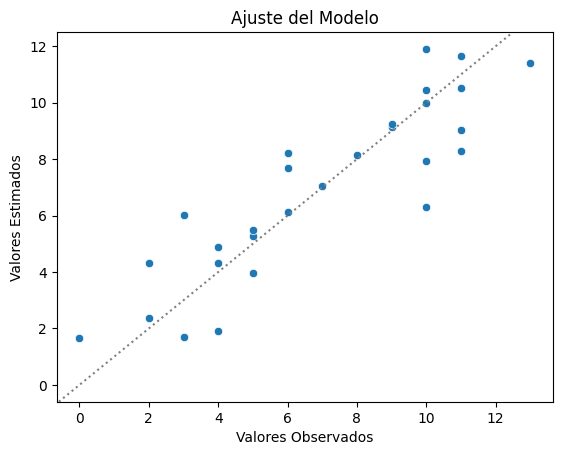

In [ ]:
# Plot de los valores esperados (observados) y estimados

fig , axes = plt.subplots()

EstimateValuesY = DataMatrixX@EstimateBetas
sns.scatterplot(
    x = RealValuesY[:,0],
    y = EstimateValuesY[:,0],
    ax = axes,
)

axes.axline(
    (0,0),
    slope = 1,
    color = 'gray',
    linestyle = ':',
)

axes.set_title('Ajuste del Modelo')
axes.set_xlabel('Valores Observados')
axes.set_ylabel('Valores Estimados');

## **e**. Gráfica de Probabilidad Normal de los Residuales

Se tiene que la parte central del Q-Q plot tiene una ligera forma de S, esto implica que existe un ligero sesgo en los residuales centrales, por lo que el modelo se podría refinar para mejorar sus predicciones.

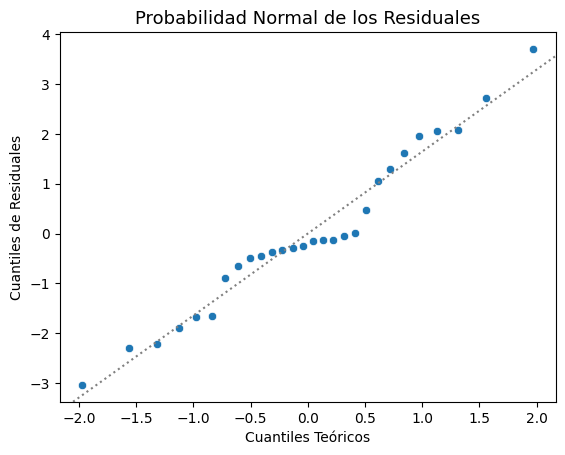

In [139]:
# Plot

QuantilesTheoObs , RegressionLineParams = stats.probplot(
    LinearModel.resid,
    dist = 'norm',
)

fig , axes = plt.subplots()
sns.scatterplot(
    x = QuantilesTheoObs[0],
    y = QuantilesTheoObs[1],
    ax = axes,
)

axes.axline(
    (0,0),
    slope=RegressionLineParams[0],
    color = 'gray',
    linestyle = ':',
)

axes.set_xlabel('Cuantiles Teóricos')
axes.set_ylabel('Cuantiles de Residuales')
axes.set_title('Probabilidad Normal de los Residuales',size=13);

## **f**. Gráfica de los Residuales en Función de la Respuesta Predicha

Como en el plot presentado no figura algún patrón o curva, podría ser indicio de que los residuales represntan la parte aleatoria o ruido propio de cada instancia (observación). Por lo tanto, se tiene un modelo bien ajustado.

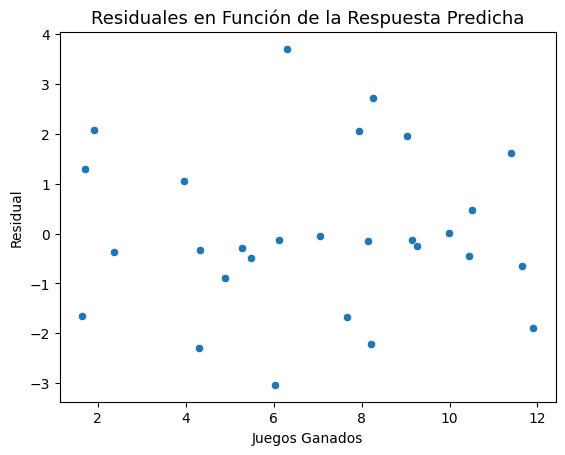

In [147]:
# Plot

fig , axes = plt.subplots()
sns.scatterplot(
    x = LinearModel.fittedvalues,
    y = LinearModel.resid,
    ax = axes,
)

axes.set_xlabel('Juegos Ganados')
axes.set_ylabel('Residual')
axes.set_title('Residuales en Función de la Respuesta Predicha',size=13);

## **g**. Gráficas de los Residuales en Función de las Variables Regresoras

En la variable $x_2$ no parece que tengan algún patrón o curva, en cambio, en las variables $x_7$ y $x_8$, se puede apreciar zonas donde incrementan y decrementan, esto significa que posiblemente los datos no siguen un patrón homocedástico.

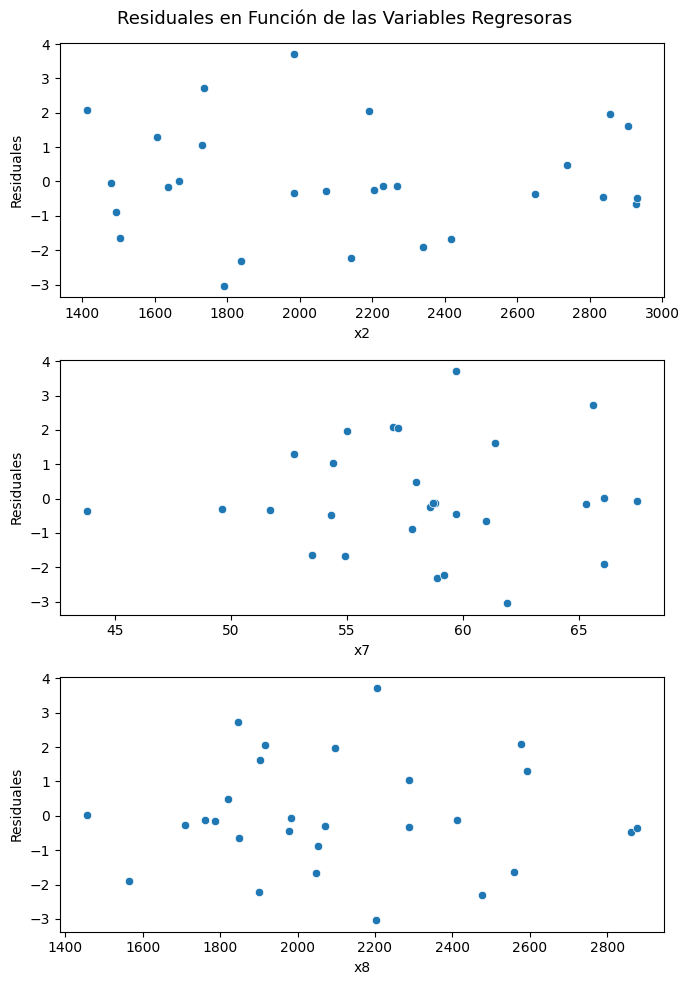

In [155]:
fig , axes = plt.subplots(
    3,
    figsize = (7,10),
    layout = 'tight',
)

for feature , ax in zip(FeaturesModel,axes.ravel()):
    sns.scatterplot(
        x = DatasetFutbol[feature],
        y = LinearModel.resid,
        ax = ax,
    )
    ax.set_ylabel('Residuales')

fig.suptitle('Residuales en Función de las Variables Regresoras',size=13);

## **h**. Intervalos de Confianza

### 1. Coeficiente de Regresión $\beta_7$

La longitud del intervalo de confianza para $\beta_7$ es amplio en comparación con el generado para los otros dos coeficientes, esto representa que se tiene una mayor incertidumbre sobre el valor de este coeficiente.

In [184]:
def ConfidenceIntervalsCoefficient(
        LinearModel,
        Dataset: pd.DataFrame,
        FeaturesModel: list[str],
        IndexFeatures: list[int],
        LevelSignificance: float = 0.05,
    ) -> None:
    """
    Función para determinar los intervalos de 
    confianza para los coeficientes de 
    regresión de un modelo.
    """

    CovarianceEstimateBetas = CalculatedCovarianceEstimateBetas(LinearModel,Dataset,FeaturesModel)
    
    tValue_1 = stats.t.ppf(1 - LevelSignificance/2,LinearModel.df_resid)
    for index_feature in IndexFeatures:
        beta_value = LinearModel.params.iloc[index_feature]
        interval_borders = tValue_1*np.sqrt(CovarianceEstimateBetas[index_feature+1,index_feature+1])
        left_interval = beta_value - interval_borders
        right_interval = beta_value + interval_borders
        print(f'{FeaturesModel[index_feature]} , {beta_value} :: [{left_interval} , {right_interval}] , Longitud {right_interval-left_interval}')

In [ ]:
# Intervalos de Confianza para Coeficientes

ConfidenceIntervalsCoefficient(
    LinearModel,
    DatasetFutbol,
    FeaturesModel,
    [0,1,2],
)

x2 , -1.808372058704668 :: [-1.8098064652139283 , -1.806937652195408] , Longitud 0.0028688130185203775
x7 , 0.003598070213976692 :: [-0.17850681780157873 , 0.1857029582295321] , Longitud 0.3642097760311108
x8 , 0.19396020958321789 :: [0.1913246765658257 , 0.19659574260061008] , Longitud 0.0052710660347843885


### 2. Respuesta Media

El intervalo de confianza es de un tamaño relativa grande, por lo que se tiene que la respuesta no es concisa. Pero al comparar cómo son los intervalos de confianza para instancias cuya cantidad de juegos ganados sea 6, 7 u 8 se generan intervalos de confianza de este tamaño o mayores, por lo que el modelo podría estar generando predicciones no tan robustas o precisas.

In [190]:
def ConfidenceIntervalsMeanResponse(
        LinearModel,
        Dataset: pd.DataFrame,
        FeaturesModel: list[str],
        Observations: pd.DataFrame,
        LevelSignificance: float = 0.05,
    ) -> None:
    """
    Función para determinar los intervalos de 
    confianza para la respuesta/predicción 
    media del modelo.
    """

    CovarianceEstimateBetas = CalculatedCovarianceEstimateBetas(LinearModel,Dataset,FeaturesModel)
    
    tValue_1 = stats.t.ppf(1 - LevelSignificance/2,LinearModel.df_resid)
    for index_observation , observation in enumerate(Observations.iloc):
        actual_values = observation[FeaturesModel]
        values_x = np.concat([[1],actual_values])[:,None]
        prediction = LinearModel.predict(observation).iloc[0]

        var_prediction = (values_x.T@CovarianceEstimateBetas@values_x)[0,0]
        interval_borders = tValue_1*np.sqrt(var_prediction)

        left_interval = prediction - interval_borders
        right_interval = prediction + interval_borders
        print(f'[{index_observation}] :: {left_interval} <= {prediction} <= {right_interval} , Longitud {right_interval-left_interval}')

In [201]:
# Intervalo de confianza para la Respuesta Media

Observations = pd.DataFrame(
    [
        [2300,56,2100]
    ],
    columns = FeaturesModel,
)

ConfidenceIntervalsMeanResponse(
    LinearModel,
    DatasetFutbol,
    FeaturesModel,
    Observations,
)

[0] :: 6.43620277665725 <= 7.216423832995973 <= 7.996644889334696 , Longitud 1.5604421126774461


In [205]:
ConfidenceIntervalsMeanResponse(
    LinearModel,
    DatasetFutbol,
    FeaturesModel,
    DatasetFutbol.query(f'{TargetLabel} in [6,7,8]')
)

[0] :: 5.42396531271377 <= 7.055145968267942 <= 8.686326623822113 , Longitud 3.262361311108343
[1] :: 7.425049128172527 <= 8.219688569466038 <= 9.01432801075955 , Longitud 1.5892788825870232
[2] :: 4.974294566824996 <= 6.127359527337713 <= 7.28042448785043 , Longitud 2.306129921025434
[3] :: 6.701774204605457 <= 7.670849433718352 <= 8.639924662831246 , Longitud 1.9381504582257891
[4] :: 6.921714728758598 <= 8.15039640706317 <= 9.379078085367741 , Longitud 2.457363356609143


## **i**. Modelo de Regresión Alternativo

Como se mencionó en la sección [a. Modelo de Regresión](#a-modelo-de-regresión), la variable $x_2$ no figuraba con una tendencia pronunciada respecto a la variable de respuesta. Al momento de aplicar la prueba sobre la significancia de la regresión, sí es significativa pero igual no se obtuvo un estadístico $F_0$ notariamente mayor que $F_1$, e incluso los cuadrados medios empeoraron respecto al anterior modelo.

In [210]:
# Ajuste de Modelo Alternativo usando Funciones de Python 

FeaturesModel_Alt = ['x7','x8']

LinearModel_Alt = smf.ols(
    f"{TargetLabel} ~ " + ' + '.join(FeaturesModel_Alt),
    data = DatasetFutbol,
).fit()

In [215]:
# Ajuste de Modelo Alternativo de forma Manual

DataMatrixX_Alt = np.concat(
        [
            np.ones((SizeN,1)),
            DatasetFutbol[FeaturesModel_Alt].to_numpy()
        ],
        axis=1,
    )

EstimateBetas_Alt = np.linalg.inv(DataMatrixX_Alt.T@DataMatrixX_Alt) @ DataMatrixX_Alt.T @ RealValuesY

In [221]:
# Tabla de ANOVA con el nuevo modelo

print(f'F_1 :: {F_1}')

ANOVA_Alt = ANOVATable(LinearModel_Alt)
ANOVA_Alt

F_1 :: 3.0087865704473615


,Suma de Cuadrados,Grados de Libertad,Cuadrados Medios,F_0
Fuente Variación,,,,
Regresión,179.066188,2.0,89.533094,15.134254
Residuales,147.898098,25.0,5.915924,NaN
Total,326.964286,27.0,12.109788,NaN


## **j**. Métricas del Modelo Alternativo

Como se mencionó en la sección anterior, [i. Modelo de Regresión Alternativo](#i-modelo-de-regresión-alternativo), este modelo tiene un peor comportamiento para predecir respecto al anterior, y esto se muestra al considerar las métricas que tiene las cuales decayeron en $0.2$ puntos. Junto con que las predicciones generadas por este nuevo modelo se encuentran más dispersas respecto a los valores reales, no se alinean a la identidad.

In [222]:
# Scores usando el Modelo

print(f'R^2 :: {LinearModel_Alt.rsquared}')
print(f'R^2 Adjustada:: {LinearModel_Alt.rsquared_adj}')

R^2 :: 0.5476628350557938
R^2 Adjustada:: 0.5114758618602573


In [223]:
# Scores usando Operaciones Manuales

RSquared = float.__truediv__(*ANOVA_Alt['Suma de Cuadrados'][['Regresión','Total']])
RSquared_Adj = 1-((1-RSquared)*ANOVA_Alt.loc['Total','Grados de Libertad'])/(ANOVA_Alt.loc['Residuales','Grados de Libertad'])

print(f'R^2 :: {RSquared}')
print(f'R^2 Adjustada:: {RSquared_Adj}')

R^2 :: 0.5476628350557938
R^2 Adjustada:: 0.5114758618602573


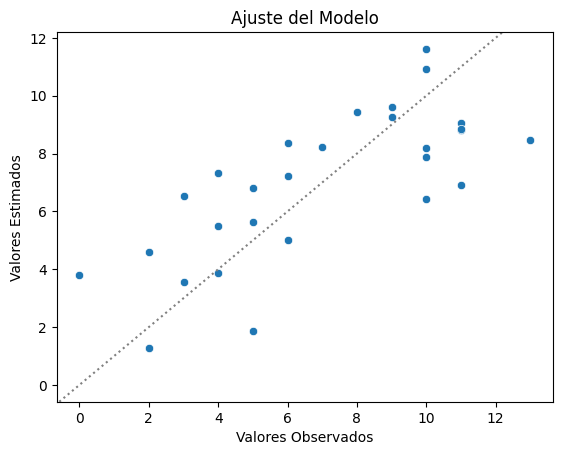

In [224]:
# Plot de los valores esperados (observados) y estimados

fig , axes = plt.subplots()

EstimateValuesY_Alt = DataMatrixX_Alt@EstimateBetas_Alt
sns.scatterplot(
    x = RealValuesY[:,0],
    y = EstimateValuesY_Alt[:,0],
    ax = axes,
)

axes.axline(
    (0,0),
    slope = 1,
    color = 'gray',
    linestyle = ':',
)

axes.set_title('Ajuste del Modelo')
axes.set_xlabel('Valores Observados')
axes.set_ylabel('Valores Estimados');

## **k**. Intervalos de Confianza en el Modelo Alternativo

### 1. Coeficiente de Regresión $\beta_7$

Se generó un intervalo de una mayor longitud, esto se relaciona con que existe una mayor incertidumbre sobre el valor real de $\beta_7$ y sobre su importancia para predecir la variable de respuesta. Todo esto provoca que se incremente la longitud del intervalo y pierda robustez este nuevo modelo.

In [227]:
# Intervalos de Confianza para Coeficientes

ConfidenceIntervalsCoefficient(
    LinearModel_Alt,
    DatasetFutbol,
    FeaturesModel_Alt,
    [0],
)

x7 , 17.94431852007709 :: [17.69878336645282 , 18.18985367370136] , Longitud 0.49107030724854184


### 2. Respuesta Media

Debido al deterioro de este nuevo modelo, los intervalos de confianza incrementaron, haciendo que la respuesta media de las predicciones tengan intervalos de confianza tamaños más grandes; como lo que pasó en este caso, el cual se hizo 0.6 más grande, es decir, una mayor incertidumbre sobre la predicción.

In [228]:
ConfidenceIntervalsMeanResponse(
    LinearModel_Alt,
    DatasetFutbol,
    FeaturesModel_Alt,
    Observations,
)

[0] :: 5.8286434997258 <= 6.92624256625235 <= 8.0238416327789 , Longitud 2.1951981330531005
